In [1]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""


import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.gae.optimizer import optimizerAE, optimizerVAE,get_roc_score,accuracy
from gae.gae.model import GCNModelAE, GCNModelVAE
import gae.gae.model
from gae.gae.preprocessing import preprocess_graph, sparse_to_tuple, mask_test_edges,sparse_mx_to_torch_sparse_tensor
import gae.gae.preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy
import umap
import pandas as pd

In [2]:
# Settings
use_cuda=False
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
maskedgeName='cycif_random20_connectivity'
epochs=200
lr=0.01 #initial learning rate
weight_decay=5e-4 #Weight for L2 loss on embedding matrix.
hidden1=10 #Number of units in hidden layer 1
hidden2=4 #Number of units in hidden layer 2
# hidden3=16
dropout=0
testEdges=0.1 #fraction of total edges for testing
valEdges=0.05 #fraction of total edges for validation
crossValidation=False
ncrossVal=6
randFeatureSubset=None
model_str='gcn_vae' #currently available choices: gcn_vae, gcn_ae
adj_path=os.path.join('/nfs','latdata','xinyi','cycif_data_for_gae','xamatrices','a','random20_connectivity.npz')
features_path=os.path.join('/nfs','latdata','xinyi','cycif_data_for_gae','xamatrices','x','standardize.npz')

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)

# Load data
adj=sp.load_npz(adj_path)
features=sp.load_npz(features_path)
if randFeatureSubset != None:
    idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
    features=features[:,idx]
features=sparse_mx_to_torch_sparse_tensor(features)
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj = adj+ sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)

In [3]:
if useSavedMaskedEdges and os.path.exists('gae/maskedEdges/'+maskedgeName+'_seed'+str(seed)+'.pkl'):
    print('opening saved')
    with open('gae/maskedEdges/'+maskedgeName+'_seed'+str(seed)+'.pkl', 'rb') as input:
        maskedgeres = pickle.load(input)
else:
    # construct training, validation, and test sets
    maskedgeres= mask_test_edges(adj,crossValidation,ncrossVal=ncrossVal,testSize=testEdges,valSize=valEdges)
    with open('gae/maskedEdges/'+maskedgeName+'_seed'+str(seed)+'.pkl', 'wb') as output:
        pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)


In [4]:

train_loss=[None]*len(maskedgeres)
train_acc=[None]*len(maskedgeres)
val_loss=[None]*len(maskedgeres)
val_ap=[None]*len(maskedgeres)
val_roc=[None]*len(maskedgeres)
# loop over all train/validation sets
for seti in range(len(maskedgeres)):
    adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = maskedgeres[seti]
    
    adj_norm = gae.gae.preprocessing.preprocess_graph(adj_train)
    adj_label=adj_train + sp.eye(adj_train.shape[0])
    adj_label=torch.tensor(adj_label.todense())
    
    num_nodes,num_features = features.shape

    # Create model
    if model_str == 'gcn_ae':
        model = gae.gae.model.GCNModelAE(num_features, hidden1, hidden2, dropout)
        loss_function=optimizerAE
    elif model_str == 'gcn_vae':
        model  = gae.gae.model.GCNModelVAE(num_features, hidden1, hidden2, dropout)
        loss_function=optimizerVAE
    elif model_str=='gcn_vae3':
        model  = gae.gae.model.GCNModelVAE3(num_features, hidden1, hidden2,hidden3, dropout)
        loss_function=optimizerVAE
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    pos_weight = float(adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) / adj_train.sum()
    pos_weight=torch.tensor(pos_weight)
    norm = adj_train.shape[0] * adj_train.shape[0] / float((adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) * 2)

    if use_cuda:
        model.cuda()
        features = features.cuda()
        adj_norm=adj_norm.cuda()
        adj_label = adj_label.cuda()
        train_edges = train_edges.cuda()
        val_edges = val_edges.cuda()
        val_edges_false=val_edges_false.cuda()
        test_edges=test_edges.cuda()
        test_edges_false=test_edges_false.cuda()
    
    def train(epoch):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        adj_recon,mu,logvar = model(features, adj_norm)
#         print(adj_recon)
#         print(adj_label)
        loss = loss_function(adj_recon,adj_label, mu, logvar, num_nodes, pos_weight, norm)
        acc_train = accuracy(adj_recon, adj_label)
        loss.backward()
        optimizer.step()

        if not fastmode:
            # Evaluate validation set performance separately,
            # deactivates dropout during validation run.
            model.eval()
            adj_recon,mu,logvar = model(features, adj_norm)
            
        loss_val = optimizerAE(adj_recon,adj_label, mu, logvar, num_nodes, pos_weight, norm)
        roc_val,ap_val=get_roc_score(val_edges, val_edges_false,adj_recon,adj_orig)
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'roc_val: {:.4f}'.format(roc_val),
              'ap_val: {:.4f}'.format(ap_val),
              'time: {:.4f}s'.format(time.time() - t))
        return loss.item(),acc_train.item(),loss_val.item(),roc_val,ap_val
    
    print('cross-validation ',seti)
    train_loss_ep=[None]*epochs
    train_acc_ep=[None]*epochs
    val_loss_ep=[None]*epochs
    val_ap_ep=[None]*epochs
    val_roc_ep=[None]*epochs
    t_ep=time.time()
    for ep in range(epochs):
        train_loss_ep[ep],train_acc_ep[ep],val_loss_ep[ep],val_roc_ep[ep],val_ap_ep[ep]=train(ep)
    train_loss[seti]=train_loss_ep
    train_acc[seti]=train_acc_ep
    val_loss[seti]=val_loss_ep
    val_ap[seti]=val_ap_ep
    val_roc[seti]=val_roc_ep
    print('total time: {:.4f}s'.format(time.time() - t_ep))
# model.eval()
# adj_recon,mu,logvar = model(features, adj_norm)
# roc_test,ap_test=get_roc_score(test_edges, test_edges_false,adj_recon,adj_orig)
# print('test results',
#       'roc_test: {:.4f}'.format(roc_test),
#       'ap_test: {:.4f}'.format(ap_test))


cross-validation  0
Epoch: 0000 loss_train: 1.3909 acc_train: 0.4484 loss_val: 0.7183 roc_val: 0.5438 ap_val: 0.5752 time: 25.4163s
Epoch: 0001 loss_train: 1.2966 acc_train: 0.4446 loss_val: 0.7161 roc_val: 0.5497 ap_val: 0.5777 time: 26.2022s
Epoch: 0002 loss_train: 1.2319 acc_train: 0.4483 loss_val: 0.7142 roc_val: 0.5556 ap_val: 0.5805 time: 24.9953s
Epoch: 0003 loss_train: 1.1766 acc_train: 0.4497 loss_val: 0.7125 roc_val: 0.5616 ap_val: 0.5836 time: 24.3356s
Epoch: 0004 loss_train: 1.1205 acc_train: 0.4522 loss_val: 0.7109 roc_val: 0.5686 ap_val: 0.5871 time: 24.7436s
Epoch: 0005 loss_train: 1.0721 acc_train: 0.4528 loss_val: 0.7094 roc_val: 0.5773 ap_val: 0.5917 time: 25.0855s
Epoch: 0006 loss_train: 1.0273 acc_train: 0.4544 loss_val: 0.7080 roc_val: 0.5877 ap_val: 0.5976 time: 24.8516s
Epoch: 0007 loss_train: 0.9875 acc_train: 0.4574 loss_val: 0.7065 roc_val: 0.5992 ap_val: 0.6050 time: 24.6936s
Epoch: 0008 loss_train: 0.9527 acc_train: 0.4602 loss_val: 0.7051 roc_val: 0.6115 ap

Epoch: 0076 loss_train: 0.5931 acc_train: 0.5062 loss_val: 0.5888 roc_val: 0.7829 ap_val: 0.7583 time: 24.6014s
Epoch: 0077 loss_train: 0.5928 acc_train: 0.5058 loss_val: 0.5884 roc_val: 0.7833 ap_val: 0.7586 time: 24.0534s
Epoch: 0078 loss_train: 0.5922 acc_train: 0.5067 loss_val: 0.5881 roc_val: 0.7838 ap_val: 0.7590 time: 24.7599s
Epoch: 0079 loss_train: 0.5920 acc_train: 0.5066 loss_val: 0.5877 roc_val: 0.7842 ap_val: 0.7594 time: 24.1443s
Epoch: 0080 loss_train: 0.5916 acc_train: 0.5064 loss_val: 0.5873 roc_val: 0.7847 ap_val: 0.7598 time: 23.7442s
Epoch: 0081 loss_train: 0.5910 acc_train: 0.5067 loss_val: 0.5869 roc_val: 0.7852 ap_val: 0.7602 time: 24.3230s
Epoch: 0082 loss_train: 0.5906 acc_train: 0.5077 loss_val: 0.5865 roc_val: 0.7858 ap_val: 0.7606 time: 23.8196s
Epoch: 0083 loss_train: 0.5902 acc_train: 0.5077 loss_val: 0.5861 roc_val: 0.7864 ap_val: 0.7611 time: 24.8311s
Epoch: 0084 loss_train: 0.5898 acc_train: 0.5073 loss_val: 0.5857 roc_val: 0.7869 ap_val: 0.7616 time: 2

Epoch: 0150 loss_train: 0.5693 acc_train: 0.5115 loss_val: 0.5658 roc_val: 0.8121 ap_val: 0.7890 time: 24.8868s
Epoch: 0151 loss_train: 0.5692 acc_train: 0.5115 loss_val: 0.5657 roc_val: 0.8122 ap_val: 0.7892 time: 24.3477s
Epoch: 0152 loss_train: 0.5691 acc_train: 0.5116 loss_val: 0.5655 roc_val: 0.8123 ap_val: 0.7894 time: 23.9596s
Epoch: 0153 loss_train: 0.5689 acc_train: 0.5110 loss_val: 0.5654 roc_val: 0.8125 ap_val: 0.7897 time: 24.4656s
Epoch: 0154 loss_train: 0.5687 acc_train: 0.5111 loss_val: 0.5653 roc_val: 0.8126 ap_val: 0.7899 time: 25.1736s
Epoch: 0155 loss_train: 0.5685 acc_train: 0.5110 loss_val: 0.5651 roc_val: 0.8127 ap_val: 0.7901 time: 25.1548s
Epoch: 0156 loss_train: 0.5684 acc_train: 0.5111 loss_val: 0.5650 roc_val: 0.8128 ap_val: 0.7903 time: 24.4786s
Epoch: 0157 loss_train: 0.5683 acc_train: 0.5111 loss_val: 0.5649 roc_val: 0.8130 ap_val: 0.7905 time: 24.6022s
Epoch: 0158 loss_train: 0.5680 acc_train: 0.5109 loss_val: 0.5647 roc_val: 0.8131 ap_val: 0.7907 time: 2

In [5]:
model.eval()
adj_recon,mu,logvar = model(features, adj_norm)
roc_test,ap_test=get_roc_score(test_edges, test_edges_false,adj_recon,adj_orig)

test results roc_test: 0.8140 ap_test: 0.7944


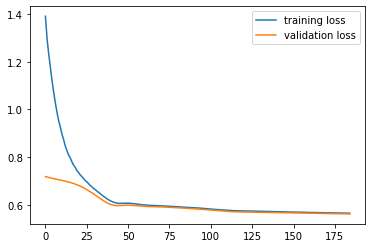

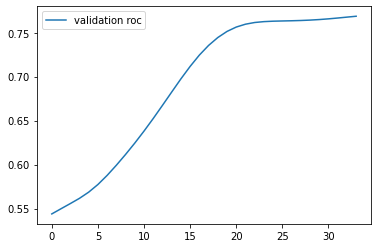

In [6]:
name='cycif_standardize_random20_connectivity_seed3_10x4'
if not os.path.exists('gae/plots/'+name):
    os.makedirs('gae/plots/'+name)
print('test results',
      'roc_test: {:.4f}'.format(roc_test),
      'ap_test: {:.4f}'.format(ap_test))
# plt.plot(np.arange(epochs),train_loss[0])
# plt.plot(np.arange(epochs),val_loss[0])
# plt.legend(['training loss','validation loss'])
# plt.savefig('gae/plots/'+name+'/loss_seed3.jpg')
# plt.show()
# plt.plot(np.arange(epochs),val_roc[0])
# plt.legend(['validation roc'])
# plt.savefig('gae/plots/'+name+'/val_roc_seed3.jpg')
# plt.show()
plt.plot(np.arange(185),train_loss_ep[:185])
plt.plot(np.arange(185),val_loss_ep[:185])
plt.legend(['training loss','validation loss'])
plt.savefig('gae/plots/'+name+'/loss_seed3.jpg')
plt.show()
plt.plot(np.arange(34),val_roc_ep[:34])
plt.legend(['validation roc'])
plt.savefig('gae/plots/'+name+'/val_roc_seed3.jpg')
plt.show()

In [7]:
torch.save(model.state_dict(), 'gae/models/'+name+'.pt')

In [8]:
## get embedding of full adjacency matrix
model.eval()
adj_norm_full = gae.gae.preprocessing.preprocess_graph(adj_orig)
adj_recon,mu,logvar = model(features, adj_norm_full)


In [9]:
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(mu.detach().numpy())

In [10]:
cycif_celltype=pd.read_csv('/nfs/latdata/xinyi/cycif_data_for_gae/cycif_metadata.csv',header=0,index_col=0).loc[:,'real_label'].to_numpy()

In [11]:
def plotumapbyCT(ctlist,savename,excludelist,embedding,title):
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("bright")
    colortest.extend(sns.color_palette("dark"))
    fig, ax = plt.subplots(dpi=400)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=ctlist==ct
        ax.scatter(
            embedding[idx, 0],
            embedding[idx, 1],
            color=colortest[celltypes_dict[ct]],label=ct,s=3,alpha=0.5
            )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(6)
    fig.set_figwidth(6)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
#     ax.legend(ncol=3)
    plt.title(title, fontsize=24)
    plt.savefig('gae/plots/'+name+'/'+savename+'.jpg')
    plt.show()

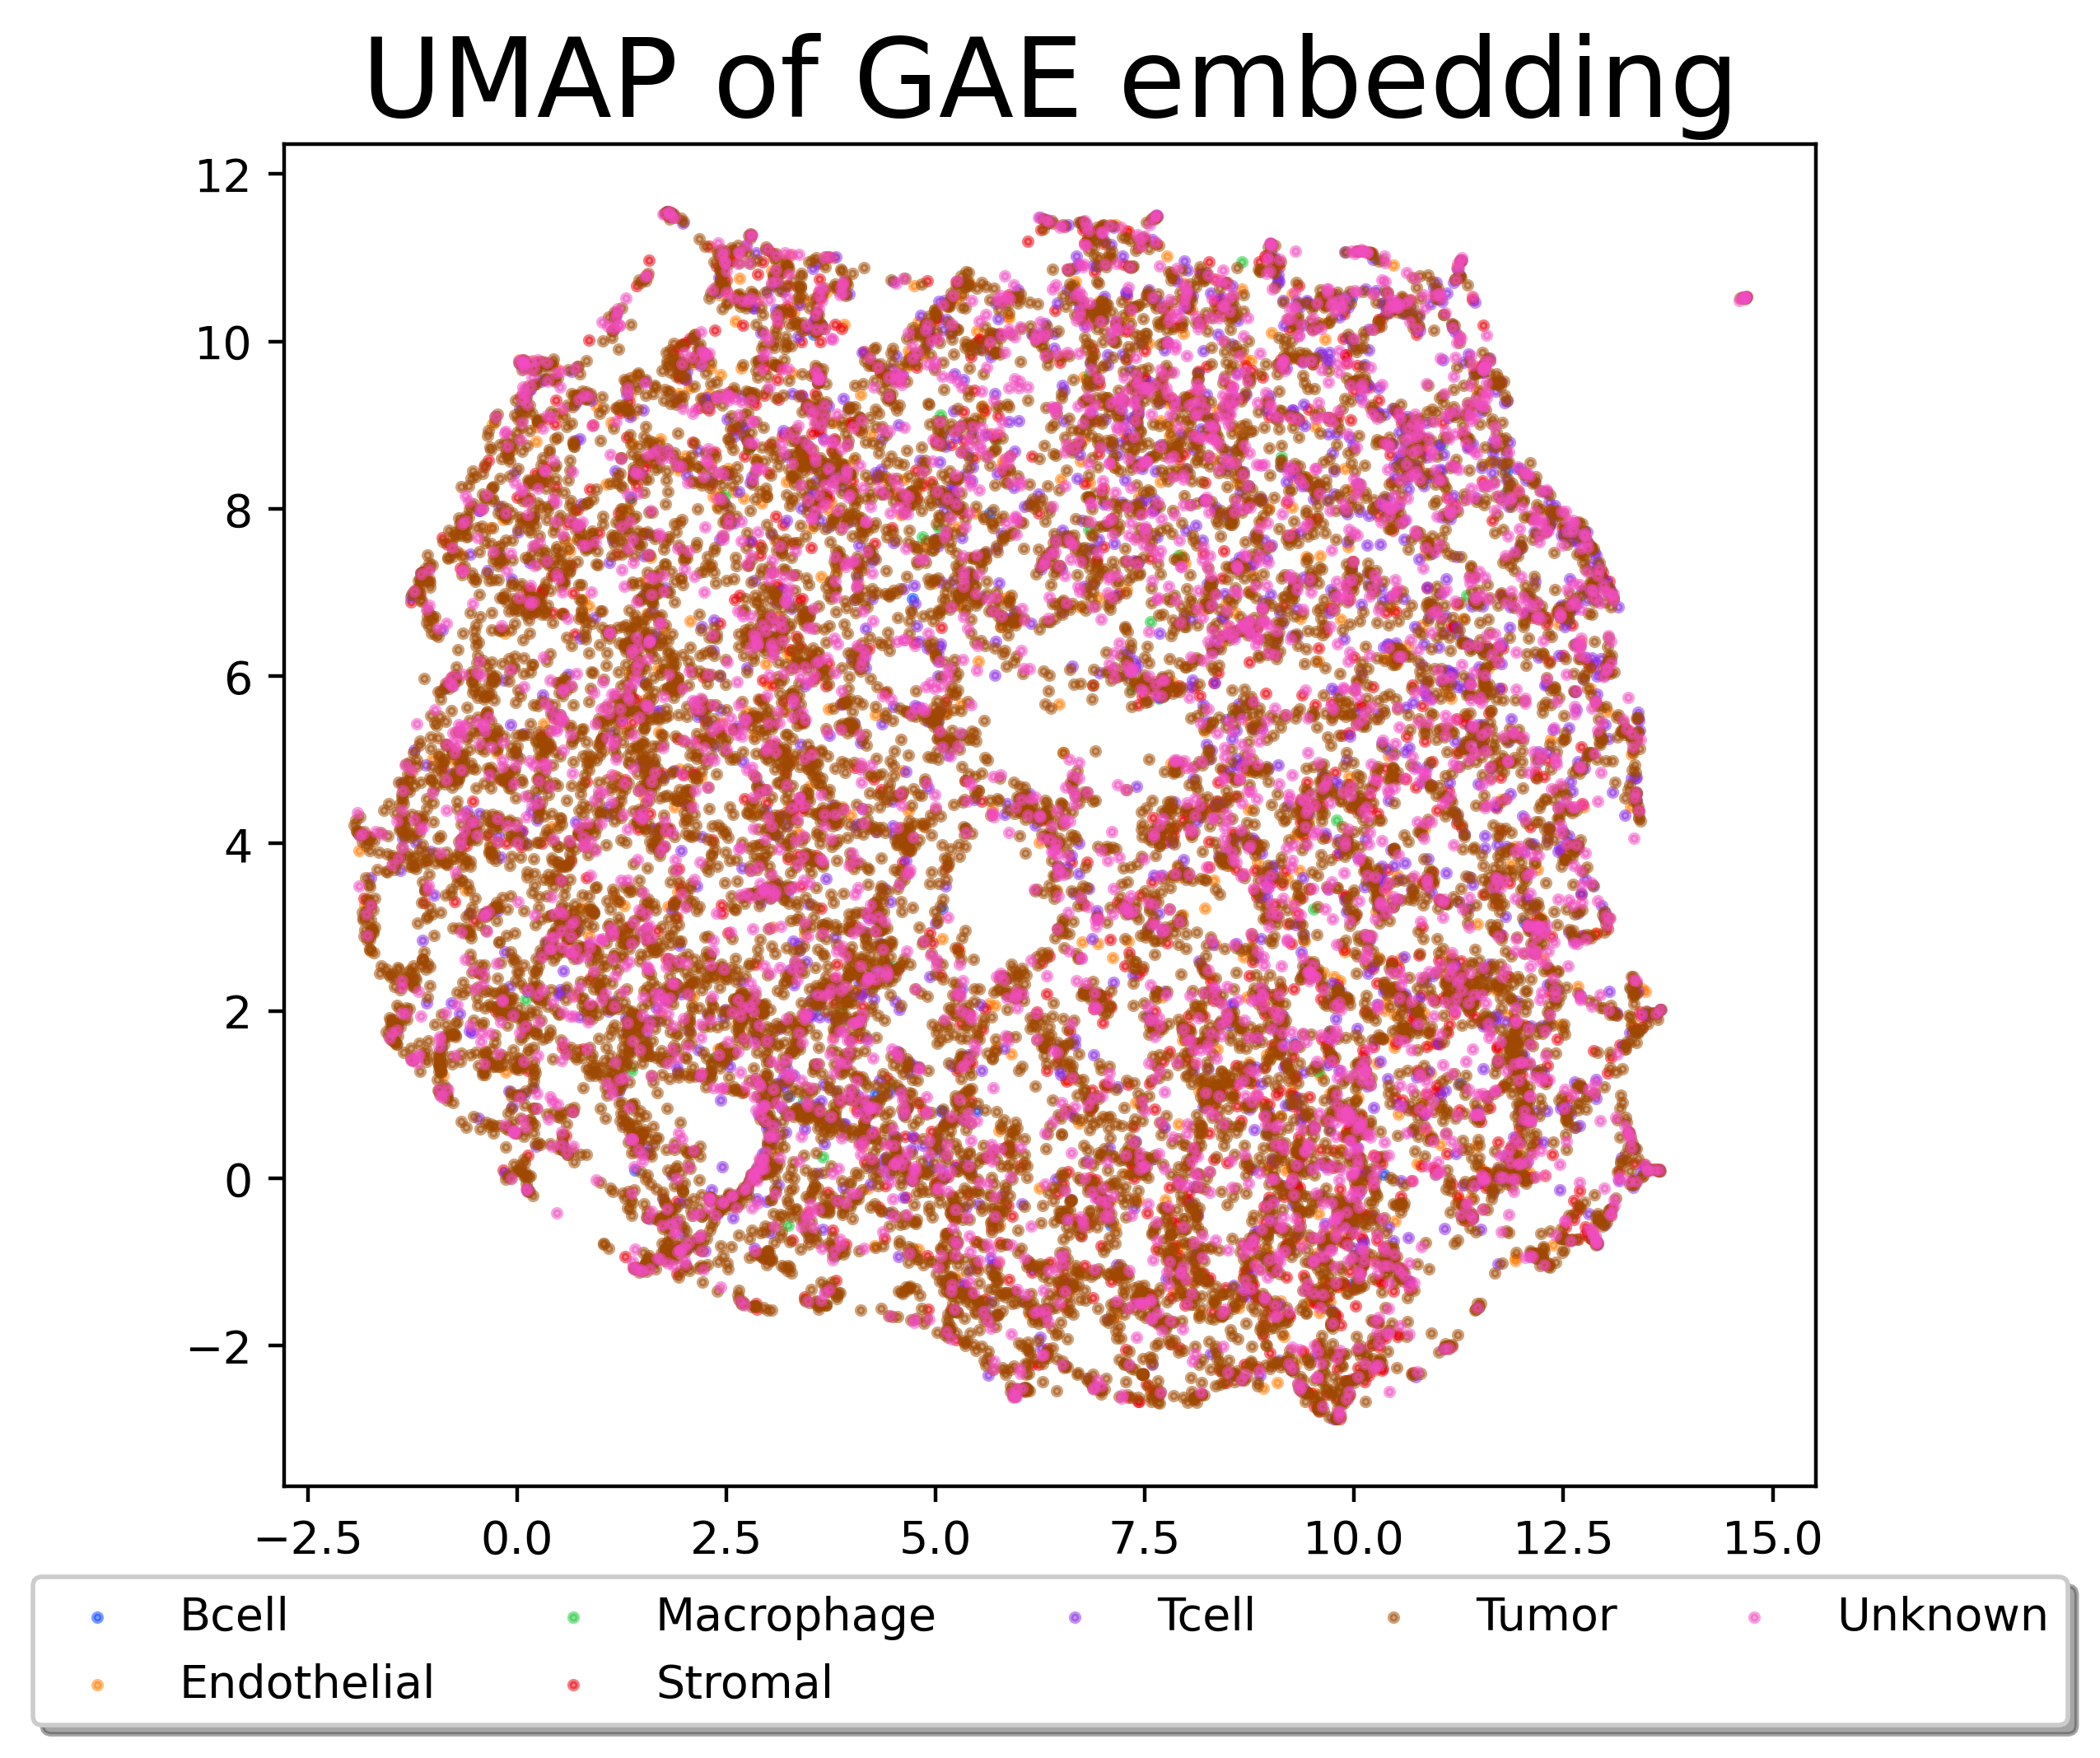

In [12]:
plotumapbyCT(cycif_celltype,'seed3_umap_byCT',[],umap_embedding,'UMAP of GAE embedding')

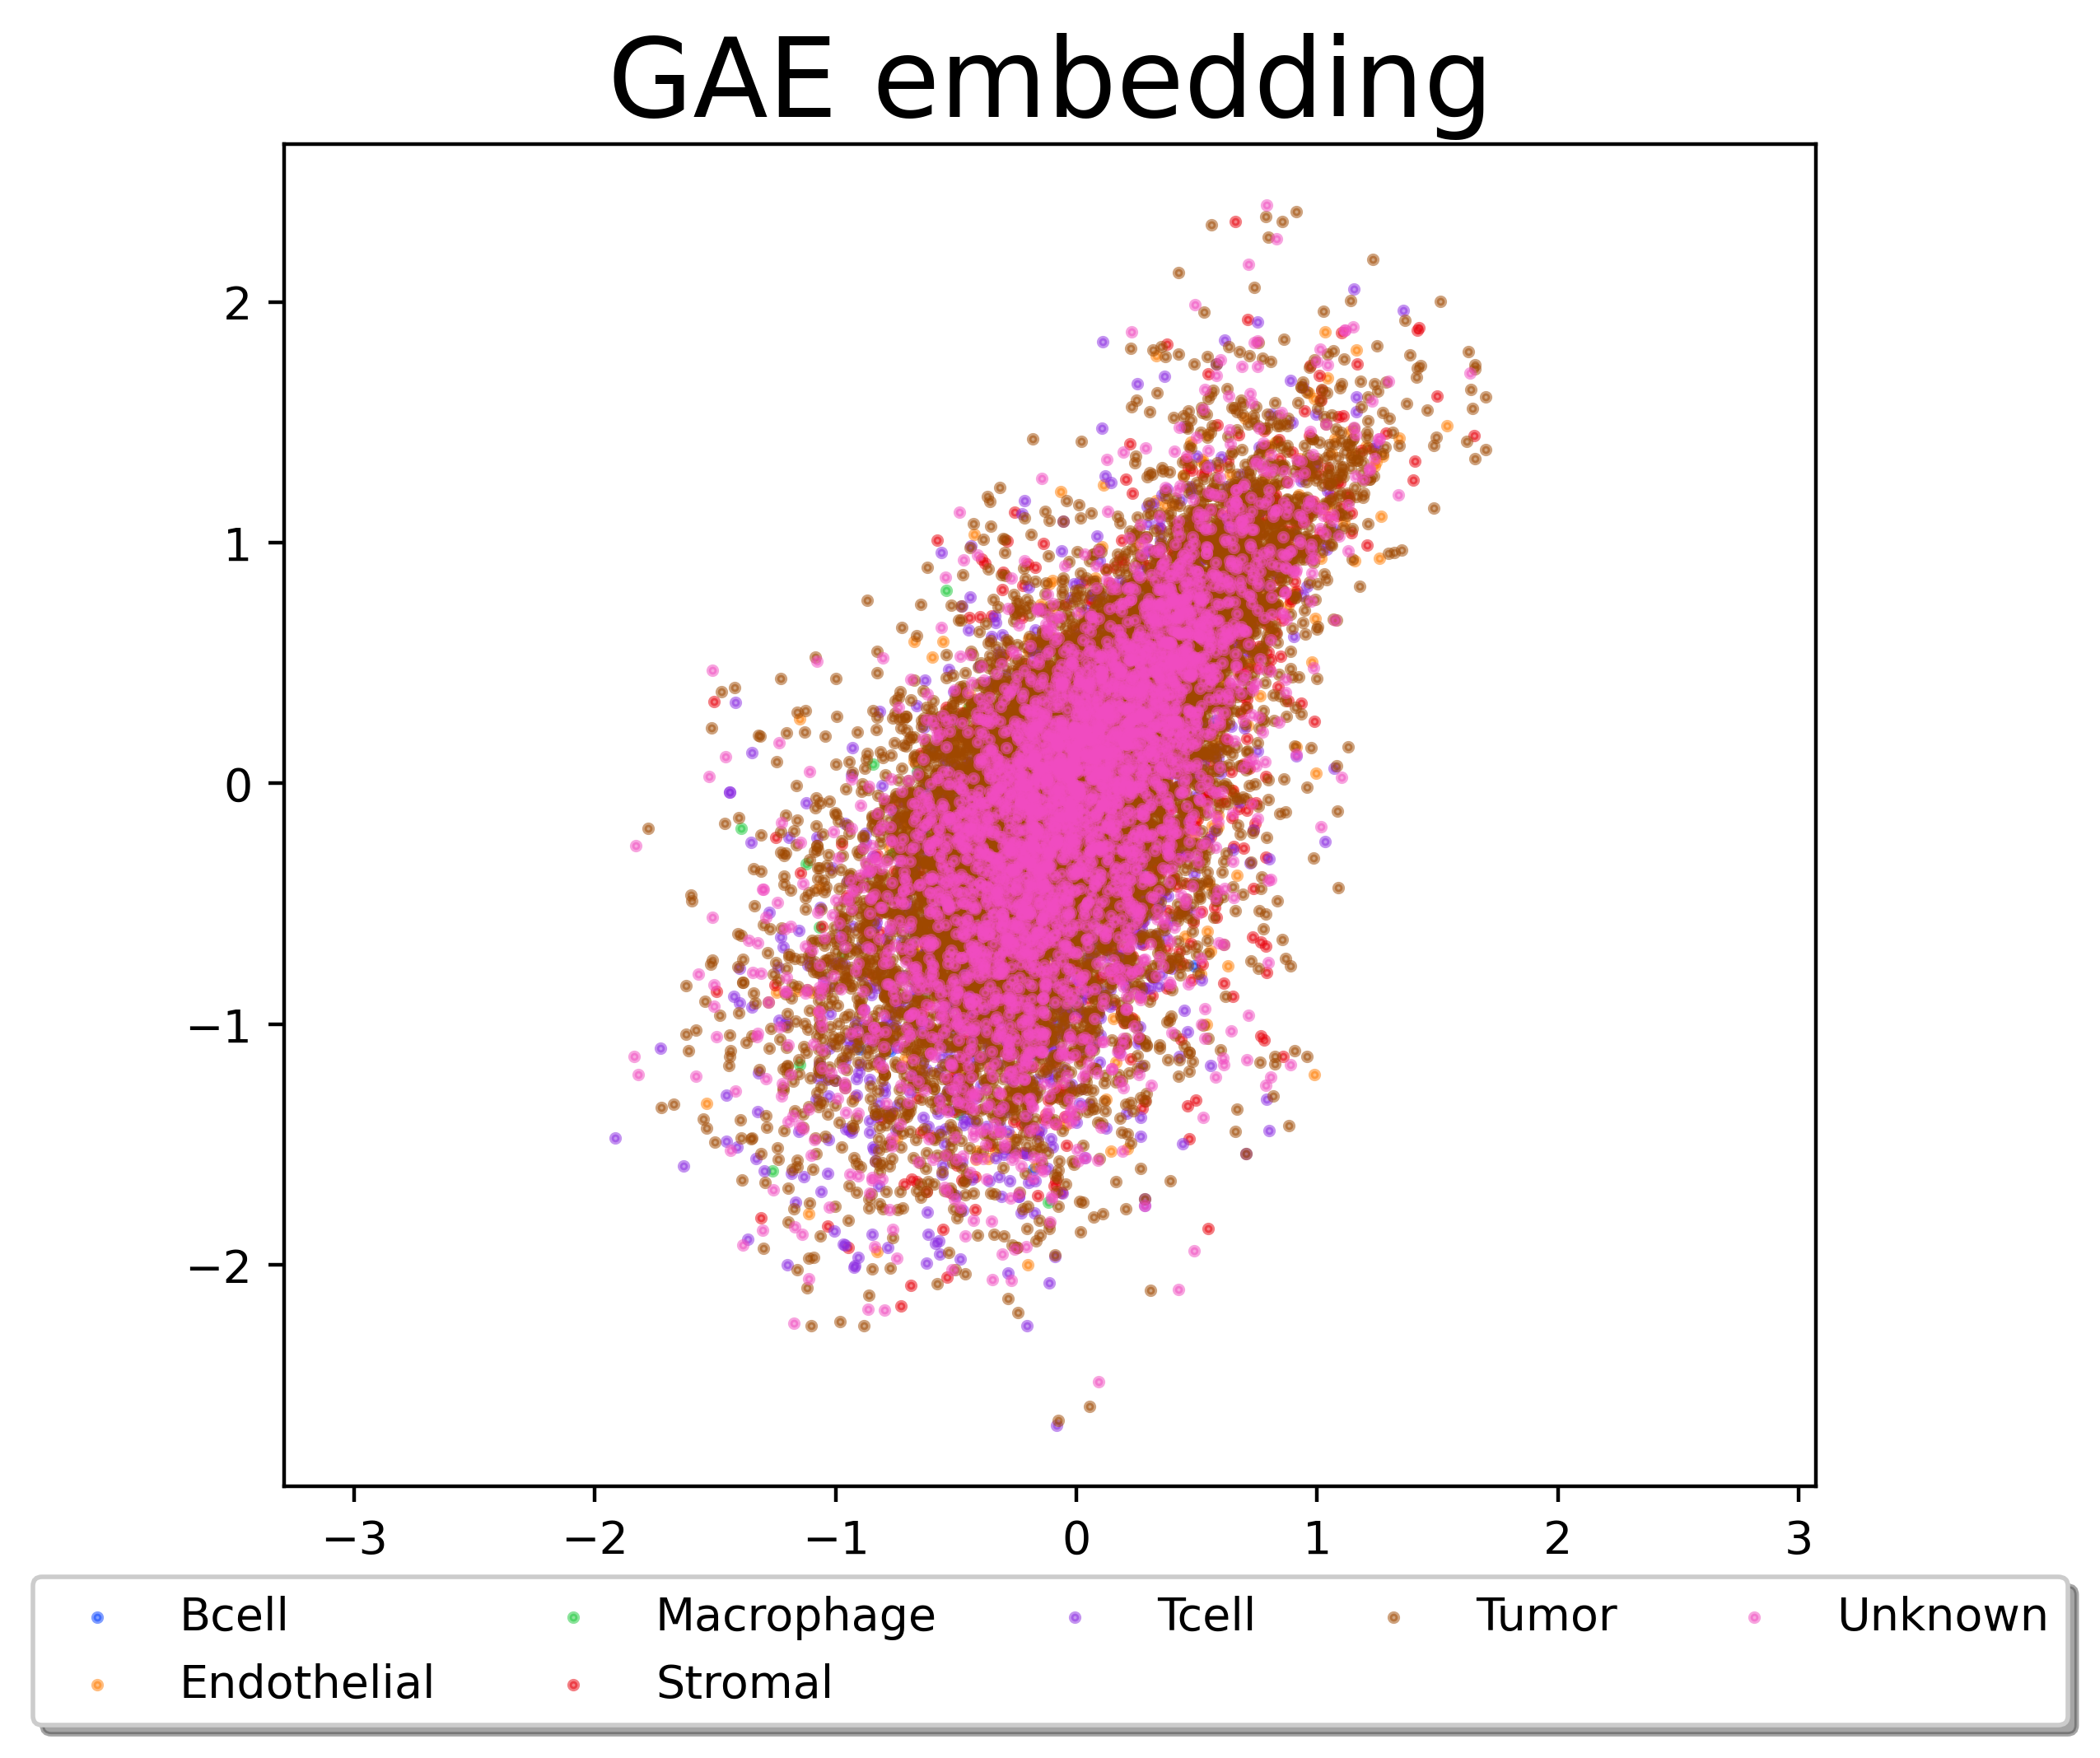

In [13]:
plotumapbyCT(cycif_celltype,'seed3_latent_byCT',[],mu.detach().numpy(),'GAE embedding')

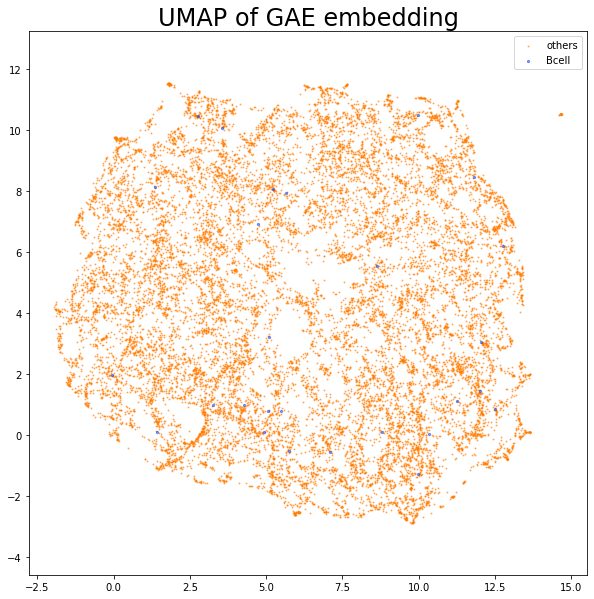

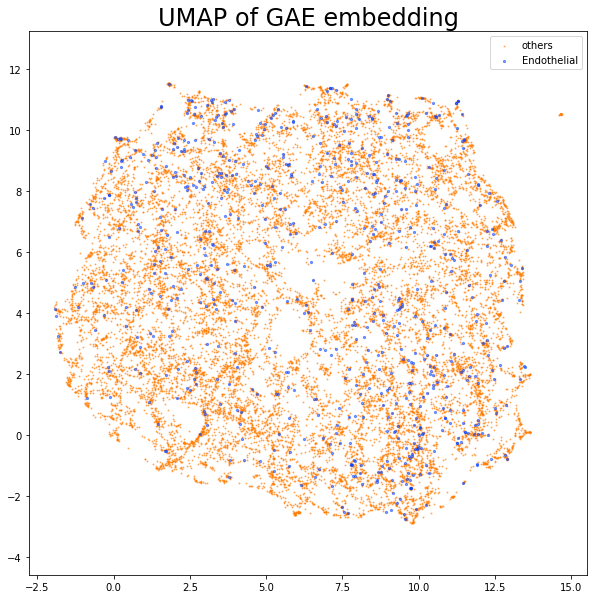

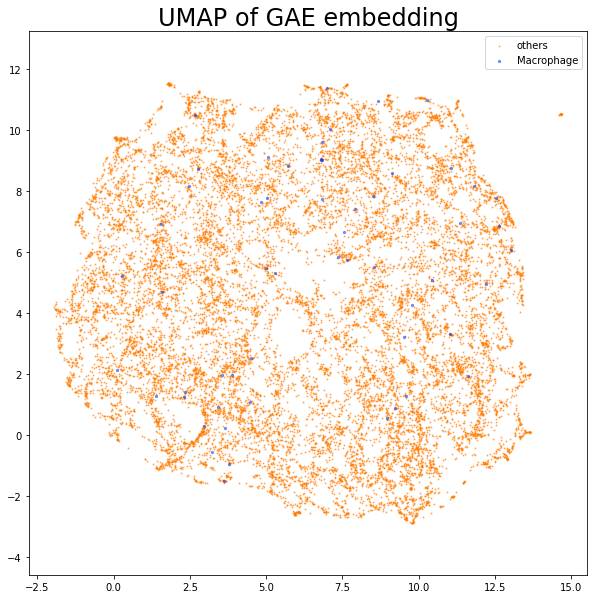

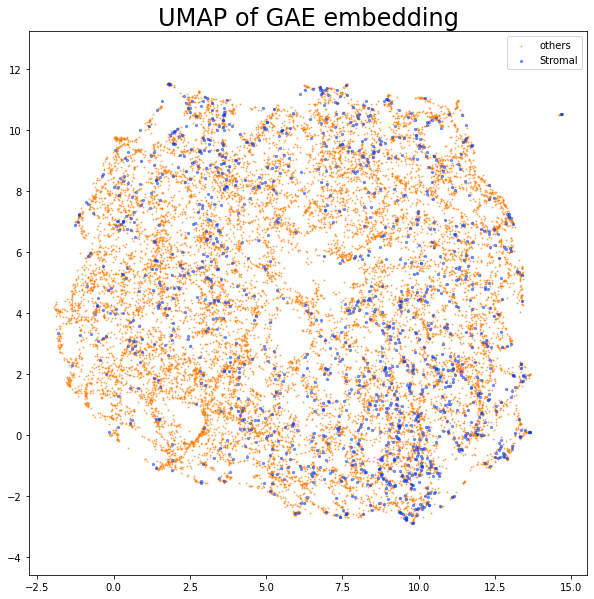

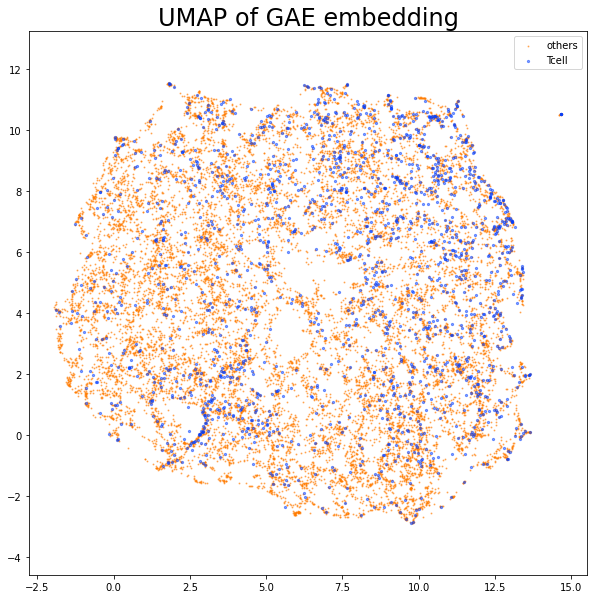

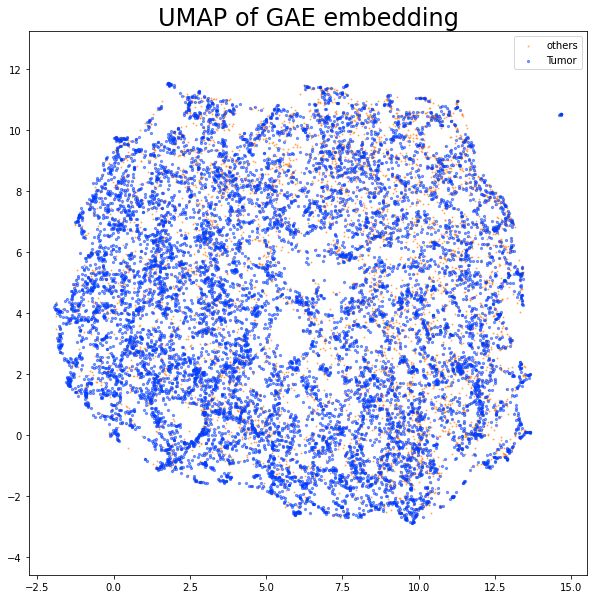

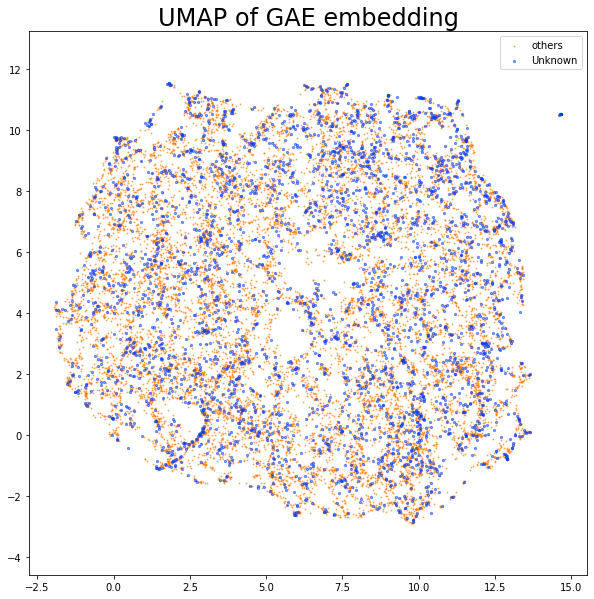

In [14]:
celltypes=np.unique(cycif_celltype)
celltypes_dict={}
idx=0
for ct in celltypes:
    celltypes_dict[ct]=idx
    idx+=1

colortest=sns.color_palette("bright")
colortest.extend(sns.color_palette("dark"))
if not os.path.exists('gae/plots/'+name+'/byCT_subcluster'):
    os.makedirs('gae/plots/'+name+'/byCT_subcluster')

for ct in celltypes:
    fig, ax = plt.subplots()
    if ct == 'Unassigned':
        continue
    
    idx=cycif_celltype!=ct
    ax.scatter(
        umap_embedding[idx, 0],
        umap_embedding[idx, 1],
        color=colortest[1],label='others',s=1,alpha=0.5
        )
    
    idx=cycif_celltype==ct
    ax.scatter(
        umap_embedding[idx, 0],
        umap_embedding[idx, 1],
        color=colortest[0],label=ct,s=5,alpha=0.5
        )
    
    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.legend()
    plt.title('UMAP of GAE embedding', fontsize=24)
    plt.gcf().savefig('gae/plots/'+name+'/byCT_subcluster/seed3_umap_byCT_subcluster_'+ct+'.jpg')
    plt.show()
#     plt.close()